# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [1]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split




In [6]:
os.environ['KERAS_HOME'] = '/Users/baudi/Library/Mobile Documents/com~apple~CloudDocs/MASTER_AI/Asignaturas/SCA/Actividades/SCA_Actividad 2/'

# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf "/Users/baudi/.keras/datasets/simpsons_train.tar.gz" -C "/Users/baudi/AI/datasets/"


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf "/Users/baudi/.keras/datasets/simpsons_test.tar.gz" -C "/Users/baudi/AI/datasets/"

In [ ]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [2]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [3]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [4]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [7]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/Users/baudi/AI/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/Users/baudi/AI/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [8]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

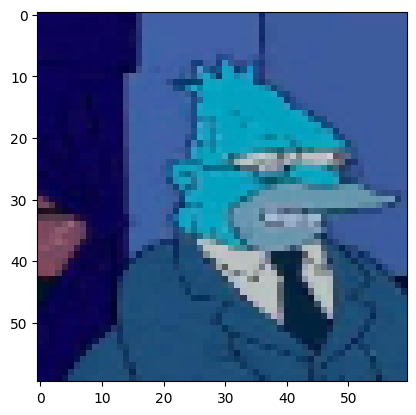

In [9]:
plt.imshow(X_t[2]) # recordad que siempre es preferible trabajar en blanco y negro


## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

Se normalizan los valores de los datasets de training y test para que estén entre 0 y 1

In [10]:
X  = X / 255.0
X_t= X_t / 255.0



Se proporciona información de los datos a utilizar

In [11]:
#número de imágenes training
print(f"Número de imágenes de training: {X.shape[0]}")
#número de imágenes test
print(f"Número de imágenes de test: {X_t.shape[0]}")
# Se obtiene el tamaño de una imagen de entrenamiento
print(f"El tamaño de las imágenes es: {X.shape[1]} x {X.shape[2]}")

Número de imágenes de training: 18992
Número de imágenes de test: 890
El tamaño de las imágenes es: 60 x 60


Se crea el dataset de validación en una proporción 80:20 respecto al de training original

In [12]:
#Dividimos el juego de datos de train, en 80% para entrenar el modelo y 20% para validarlo
train_images, val_images, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Número de imágenes de training: {train_images.shape[0]}")
#número de imágenes validación
print(f"Número de imágenes de validación: {val_images.shape[0]}")



Número de imágenes de training: 15193
Número de imágenes de validación: 3799


Se plantea el primer modelo de CNN

In [13]:
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, InceptionResNetV2
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


img_height = 60
img_width = 60
batch_size = 32
val_split = 0.2
seed = 42
num_classes = 4
learning_rate = 0.001


Se pasan los labels a variables categóricas

In [14]:
from keras.utils import to_categorical
training_labels = to_categorical(train_labels, num_classes=18)
print(len(training_labels))
validation_labels = to_categorical(val_labels, num_classes=18)
print(len(val_labels))




15193
3799


Se construye el primer modelo

In [15]:
def build_model():
    model = tf.keras.models.Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(60, 60, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),        
        Dense(18, activation='softmax')  # 4 clases: sanas, enfermedad1, enfermedad2, enfermedad3
     ])
    print(model.summary())
    return model

Se entrena el primer modelo

In [56]:
model = build_model()
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
history = model.fit(train_images, training_labels, epochs=20, batch_size=32, validation_data=(val_images, validation_labels))


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 60, 60, 64)        1792      
                                                                 
 batch_normalization_28 (Bat  (None, 60, 60, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 30, 30, 128)       73856     
                                                                 
 batch_normalization_29 (Bat  (None, 30, 30, 128)      512       
 chNormalization)                                                
                                                     

2023-05-15 23:13:52.057099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - ETA: 0s - loss: 2.5391 - accuracy: 0.3667

2023-05-15 23:14:12.943342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 23s 46ms/step - loss: 2.5391 - accuracy: 0.3667 - val_loss: 1.8267 - val_accuracy: 0.4349
Epoch 2/20
475/475 [==============================] - 20s 42ms/step - loss: 1.1444 - accuracy: 0.6599 - val_loss: 1.3444 - val_accuracy: 0.6133
Epoch 3/20
475/475 [==============================] - 20s 42ms/step - loss: 0.7313 - accuracy: 0.7837 - val_loss: 1.2615 - val_accuracy: 0.6402
Epoch 4/20
475/475 [==============================] - 20s 42ms/step - loss: 0.5426 - accuracy: 0.8408 - val_loss: 0.7105 - val_accuracy: 0.7989
Epoch 5/20
475/475 [==============================] - 20s 42ms/step - loss: 0.4265 - accuracy: 0.8756 - val_loss: 0.5475 - val_accuracy: 0.8455
Epoch 6/20
475/475 [==============================] - 20s 42ms/step - loss: 0.3402 - accuracy: 0.8988 - val_loss: 0.5240 - val_accuracy: 0.8494
Epoch 7/20
475/475 [==============================] - 20s 42ms/step - loss: 0.2962 - accuracy: 0.9150 - val_loss: 0.5857 - val_accuracy: 0.8171
Epo

Se evalua el modelo con los datos de test

In [57]:
test_labels = to_categorical(y_t, num_classes=18)
test_loss, test_accuracy = model.evaluate(X_t, test_labels)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

28/28 [==============================] - 1s 17ms/step - loss: 0.1134 - accuracy: 0.9685
Test Loss:  0.11342059075832367
Test Accuracy:  0.968539297580719


Se crea la matriz de confusión y el classification report para ver como se han comportado cada una de las clases

In [48]:
class_names = [MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]

# Matriz de confusión y métricas adicionales
Y_pred = model.predict(X_t)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(y_t, y_pred, target_names=class_names))

print('Confusion Matrix:')
print(confusion_matrix(y_t, y_pred))

 1/28 [>.............................] - ETA: 5s

2023-05-15 22:59:20.681741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 10ms/step
Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.96      0.98        48
  apu_nahasapeemapetilon       0.94      0.98      0.96        50
            bart_simpson       0.91      1.00      0.95        50
charles_montgomery_burns       0.98      0.96      0.97        48
            chief_wiggum       0.94      0.98      0.96        50
          comic_book_guy       0.98      0.98      0.98        49
          edna_krabappel       1.00      0.90      0.95        50
           homer_simpson       0.94      0.98      0.96        50
           kent_brockman       1.00      0.98      0.99        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       1.00      0.88      0.94        50
           marge_simpson       0.91      1.00      0.95        50
     milhouse_van_houten       0.96      0.98      0.97        4

Se crea un segundo modelo, en este caso de Transfer Learning usando como base la red pre-etrenada VGG19

In [26]:
def build_modelVGG19():
    # Cargar la red pre-entrenada VGG19
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    
    # Congelar todas las capas de la red base excepto las últimas 12
    for layer in base_model.layers[:-12]:
        layer.trainable = False
        
    # Añadir capas adicionales para la clasificación
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(18, activation='softmax')(x)
    
    # Crear el modelo final
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

Se entrena el modelo

In [63]:
modelvgg19 = build_modelVGG19()
history = modelvgg19.fit(train_images, training_labels, epochs=20, batch_size=64, validation_data=(val_images, validation_labels))


Epoch 1/20


2023-05-15 23:38:43.777939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - ETA: 0s - loss: 2.8264 - accuracy: 0.1013

2023-05-15 23:39:05.121380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - 25s 99ms/step - loss: 2.8264 - accuracy: 0.1013 - val_loss: 2.6328 - val_accuracy: 0.1171
Epoch 2/20
238/238 [==============================] - 22s 94ms/step - loss: 2.2279 - accuracy: 0.2809 - val_loss: 1.6981 - val_accuracy: 0.4417
Epoch 3/20
238/238 [==============================] - 22s 94ms/step - loss: 1.2765 - accuracy: 0.6095 - val_loss: 0.8295 - val_accuracy: 0.7799
Epoch 4/20
238/238 [==============================] - 22s 94ms/step - loss: 0.6229 - accuracy: 0.8263 - val_loss: 0.6201 - val_accuracy: 0.8379
Epoch 5/20
238/238 [==============================] - 22s 94ms/step - loss: 0.3844 - accuracy: 0.8938 - val_loss: 0.4984 - val_accuracy: 0.8681
Epoch 6/20
238/238 [==============================] - 23s 95ms/step - loss: 0.2642 - accuracy: 0.9279 - val_loss: 0.5329 - val_accuracy: 0.8610
Epoch 7/20
238/238 [==============================] - 23s 96ms/step - loss: 0.1911 - accuracy: 0.9475 - val_loss: 0.4965 - val_accuracy: 0.8865
Epo

Se evalua con el dataset de test

In [64]:
test_loss, test_accuracy = modelvgg19.evaluate(X_t, test_labels)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

28/28 [==============================] - 1s 32ms/step - loss: 0.1040 - accuracy: 0.9798
Test Loss:  0.10399916023015976
Test Accuracy:  0.9797753095626831


Se crea la matriz de confusión y el classification report para ver como se han comportado cada una de las clases

In [65]:
class_names = [MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]

# Matriz de confusión y métricas adicionales
Y_pred = modelvgg19.predict(X_t)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(y_t, y_pred, target_names=class_names))

print('Confusion Matrix:')
print(confusion_matrix(y_t, y_pred))

2023-05-15 23:46:24.885048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 1s 26ms/step
Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.98      0.98        48
  apu_nahasapeemapetilon       1.00      0.96      0.98        50
            bart_simpson       1.00      1.00      1.00        50
charles_montgomery_burns       0.94      0.98      0.96        48
            chief_wiggum       0.98      0.98      0.98        50
          comic_book_guy       1.00      0.96      0.98        49
          edna_krabappel       1.00      0.98      0.99        50
           homer_simpson       0.92      0.96      0.94        50
           kent_brockman       1.00      0.96      0.98        50
        krusty_the_clown       0.98      1.00      0.99        50
            lisa_simpson       1.00      0.96      0.98        50
           marge_simpson       0.98      1.00      0.99        50
     milhouse_van_houten       0.96      0.98      0.97        4

Ahora vamos con la parte de Data Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

classes_to_keep = [MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]

datagen = ImageDataGenerator(
        rescale = 1./255,
	rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)  # aquí es donde especificas la división

# Generador para el entrenamiento
train_generator = datagen.flow_from_directory(
        '/Users/baudi/AI/datasets/simpsons',  # directorio que contiene las imágenes
        target_size=(60, 60),
        batch_size=64,
        class_mode='categorical',
        classes=classes_to_keep,
        shuffle=True,
        subset='training')  # especifica que estas imágenes son para entrenamiento

# Generador para la validación
validation_generator = datagen.flow_from_directory(
        '/Users/baudi/AI/datasets/simpsons',  # nota que usamos el mismo directorio que antes
        target_size=(60, 60),
        batch_size=64,
        class_mode='categorical',
        classes=classes_to_keep,
        shuffle=False,
        subset='validation')  # especifica que estas imágenes son para validación



Found 15203 images belonging to 18 classes.
Found 3789 images belonging to 18 classes.


Adicionalmente y para que el Test Generator sea capaz de leer correctamente las imágenes de simpsons_testset, se proporciona este script que crea un directorio por clase y mueve cada imagen a su directorio correspondiente

In [17]:
import os
import shutil

# Directorio donde están todas las imágenes
src_dir = '/Users/baudi/AI/datasets/simpsons_testset'

# Obtén la lista de todas las imágenes
image_files = os.listdir(src_dir)

for img in image_files:
    # Ignora los directorios, procesa solo archivos
    if not os.path.isfile(os.path.join(src_dir, img)):
        continue

    # Obtén el nombre de la clase de la imagen (todo lo que precede al último '_')
    class_name = '_'.join(img.split('_')[:-1])

    # Define el nombre del subdirectorio
    class_dir = os.path.join(src_dir, class_name)
    
    # Si el subdirectorio no existe, crea el subdirectorio
    if not os.path.exists(class_dir):
        os.mkdir(class_dir)
    
    # Define el nombre de archivo del destino
    dst_file = os.path.join(class_dir, img)
    
    # Si el archivo de destino no existe, mueve la imagen al subdirectorio
    if not os.path.exists(dst_file):
        shutil.move(os.path.join(src_dir, img), dst_file)


Se cargan las imagenes de test

In [18]:

test_datagen = ImageDataGenerator(rescale = 1./255)  

test_generator = test_datagen.flow_from_directory(
        '/Users/baudi/AI/datasets/simpsons_testset', 
        target_size=(60, 60),
        batch_size=64,
        class_mode='categorical',
        classes=classes_to_keep,
        shuffle=False) 



Found 890 images belonging to 18 classes.


Se entrena con el primer modelo

In [33]:
model = build_modelVGG19()
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.fit(
    train_generator,
    epochs=20,
    batch_size=64,
    validation_data=validation_generator)  # ajustado para usar todos los datos


Epoch 1/20


2023-05-16 22:41:37.770238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - ETA: 0s - loss: 2.8259 - accuracy: 0.1037

2023-05-16 22:42:03.439836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - 32s 128ms/step - loss: 2.8259 - accuracy: 0.1037 - val_loss: 2.7285 - val_accuracy: 0.1185
Epoch 2/20
238/238 [==============================] - 32s 135ms/step - loss: 2.6941 - accuracy: 0.1418 - val_loss: 2.5118 - val_accuracy: 0.1916
Epoch 3/20
238/238 [==============================] - 33s 140ms/step - loss: 2.2612 - accuracy: 0.2558 - val_loss: 1.9952 - val_accuracy: 0.3610
Epoch 4/20
238/238 [==============================] - 33s 136ms/step - loss: 1.7842 - accuracy: 0.4341 - val_loss: 1.5420 - val_accuracy: 0.5339
Epoch 5/20
238/238 [==============================] - 32s 132ms/step - loss: 1.2702 - accuracy: 0.6280 - val_loss: 1.2886 - val_accuracy: 0.6213
Epoch 6/20
238/238 [==============================] - 30s 125ms/step - loss: 0.9840 - accuracy: 0.7147 - val_loss: 1.1058 - val_accuracy: 0.6825
Epoch 7/20
238/238 [==============================] - 29s 123ms/step - loss: 0.8364 - accuracy: 0.7608 - val_loss: 1.0693 - val_accuracy: 0.7

Se evalua con los datos de test

In [34]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

14/14 [==============================] - 1s 52ms/step - loss: 0.2184 - accuracy: 0.9449
Test Loss:  0.2184099406003952
Test Accuracy:  0.9449438452720642


Se crea la matriz de confusión y el classification report para ver como se han comportado cada una de las clases

In [39]:
class_names = [MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]

#Etiquetas verdaderas
y_true = test_generator.classes

# Se hace la predicción
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))

print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))

14/14 [==============================] - 1s 39ms/step
Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.85      0.89        48
  apu_nahasapeemapetilon       1.00      0.98      0.99        50
            bart_simpson       0.88      1.00      0.93        50
charles_montgomery_burns       0.98      0.90      0.93        48
            chief_wiggum       0.98      0.96      0.97        50
          comic_book_guy       0.92      0.90      0.91        49
          edna_krabappel       0.98      0.96      0.97        50
           homer_simpson       0.91      1.00      0.95        50
           kent_brockman       1.00      0.94      0.97        50
        krusty_the_clown       0.94      0.98      0.96        50
            lisa_simpson       0.92      0.88      0.90        50
           marge_simpson       0.96      0.98      0.97        50
     milhouse_van_houten       0.94      0.98      0.96        4

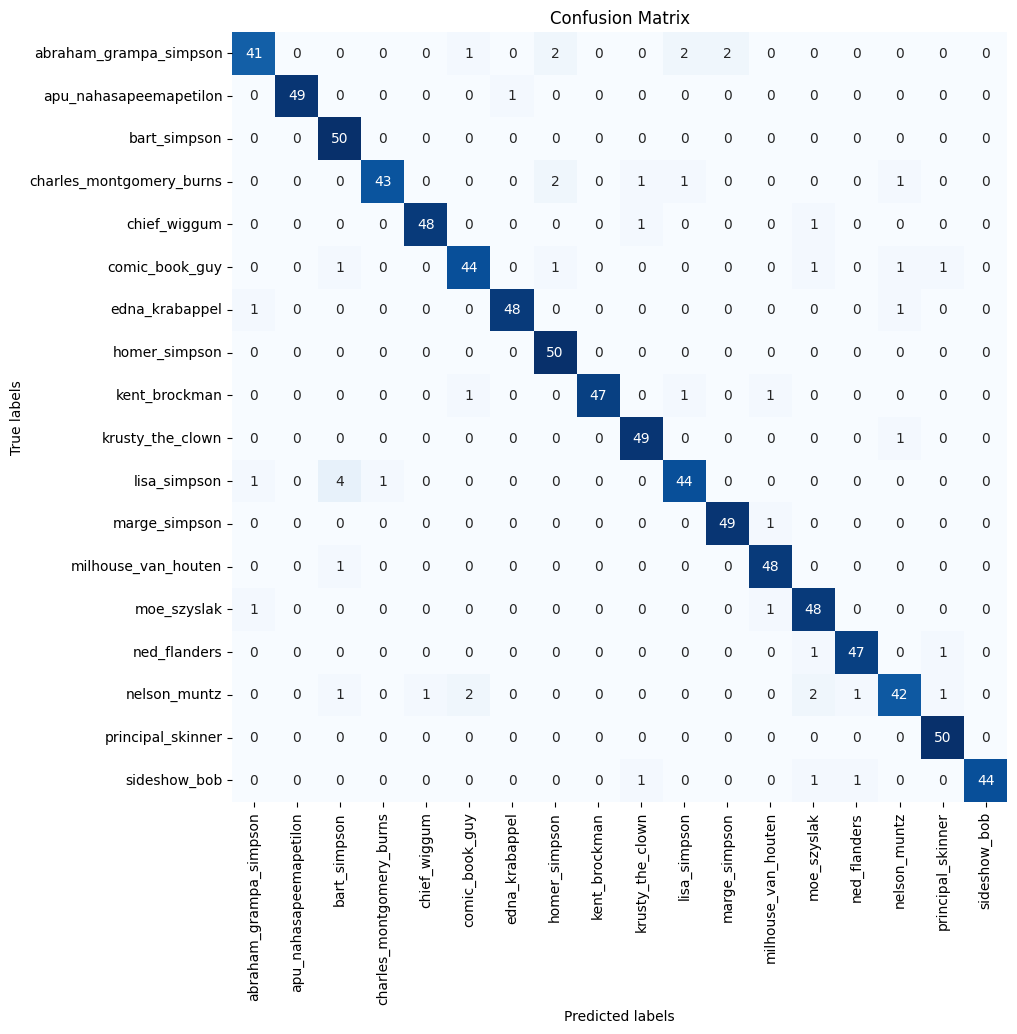

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcula la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crea una figura y un conjunto de ejes
fig, ax = plt.subplots(figsize=(10,10))

# Crea un mapa de calor a partir de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", cbar=False)

# Añade las etiquetas a los ejes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Añade las etiquetas de las clases a los ejes
ax.set_xticklabels(class_names, rotation=90)  # Etiquetas en vertical en el eje X
ax.set_yticklabels(class_names, rotation=0)   # Etiquetas en horizontal en el eje Y

# Muestra la figura
plt.show()
